In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import argparse
import collections
from pathlib import Path
import csv
import os 

import numpy as np 
import random

import torch
import torch.optim as optim
from torchvision import transforms, utils as vision_utils 
from torch.utils.tensorboard import SummaryWriter

import sys
print(sys.path)
sys.path.insert(0, "/home/egoodman/multitaskmodel/MULTITASK_FILES/RETINANET_FILES/src/pytorch-retinanet")
print(sys.path)
from retinanet import model_label_prop
from retinanet.dataloader import CocoDataset, CSVDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter, \
    Normalizer, BalancedSampler
from torch.utils.data import DataLoader

from retinanet.sampler import SamplerFactory, aggregate_indices_per_class 


from retinanet import coco_eval
from retinanet import csv_eval

assert torch.__version__.split('.')[0] == '1'

print(torch.__version__)

#https://towardsdatascience.com/reproducible-model-training-deep-dive-2a4988d69031
#reproducibility with random, np, torch, and set cuda operations to be deterministic
random.seed(666)
np.random.seed(666)
torch.manual_seed(666)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True #deterministically selects an algorithm, might cost performance



['/home/egoodman/multitaskmodel/notebooks', '/opt/conda/envs/multitaskenv/lib/python38.zip', '/opt/conda/envs/multitaskenv/lib/python3.8', '/opt/conda/envs/multitaskenv/lib/python3.8/lib-dynload', '', '/opt/conda/envs/multitaskenv/lib/python3.8/site-packages', '/opt/conda/envs/multitaskenv/lib/python3.8/site-packages/IPython/extensions', '/home/egoodman/.ipython']
['/home/egoodman/multitaskmodel/MULTITASK_FILES/RETINANET_FILES/src/pytorch-retinanet', '/home/egoodman/multitaskmodel/notebooks', '/opt/conda/envs/multitaskenv/lib/python38.zip', '/opt/conda/envs/multitaskenv/lib/python3.8', '/opt/conda/envs/multitaskenv/lib/python3.8/lib-dynload', '', '/opt/conda/envs/multitaskenv/lib/python3.8/site-packages', '/opt/conda/envs/multitaskenv/lib/python3.8/site-packages/IPython/extensions', '/home/egoodman/.ipython']
MODEL IS VideoResNet(
  (stem): R2Plus1dStem(
    (0): Conv3d(3, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
    (1): BatchNorm3d(45, eps=1e-05, mo

/opt/conda/envs/multitaskenv/lib/python3.8/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SimplexNoiseAlpha()` is deprecated. Use `BlendAlphaSimplexNoise` instead. SimplexNoiseAlpha is deprecated. Use BlendAlphaSimplexNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)
/opt/conda/envs/multitaskenv/lib/python3.8/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `FrequencyNoiseAlpha()` is deprecated. Use `BlendAlphaFrequencyNoise` instead. FrequencyNoiseAlpha is deprecated. Use BlendAlphaFrequencyNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)


1.8.0


## Set up model configs

In [4]:
LOGS_DIR = '/home/egoodman/multitaskmodel/logs/'

print('CUDA available: {}'.format(torch.cuda.is_available()))

### Set up model configs ### 

parser = argparse.ArgumentParser(description='Simple training script for training a RetinaNet network.')

parser.add_argument('--csv_train', help='Path to file containing training annotations (see readme)')
parser.add_argument('--csv_val', help='Path to file containing validation annotations (optional, see readme)')
parser.add_argument('--csv_classes', help='Path to file containing class list (see readme)')
parser.add_argument('--epochs', help='Number of epochs', type=int, default=100)
parser.add_argument('--model_name', help='Name to store the trianed model under.')
parser.add_argument('--batch_size', type=int)
parser.add_argument('--learning_rate', type=float)
parser.add_argument('--threshold', help='iou threshold to count as detection')
parser.add_argument('--sampler', help='Type of sampler to use, default aspect ratio sampler.')
parser.add_argument('--augment', action='store_true')

##### PRIMARY MODEL CONFIGS TO SET ### 

parser.model_name = '20210629_baseline_no_augmentation_no_pseudolabels'  
parser.augment = 0.9
parser.pipeline = 'my_pipeline_v2'
parser.sampler = 'new balanced' 
parser.alpha = 0.9   
parser.epochs = 100
parser.num_workers = 0


##### END PRIMARY CONFIGS ######## 

LOG_DIR = LOGS_DIR + parser.model_name + '/'
os.makedirs(LOG_DIR, exist_ok=True) 

parser.csv_train = '../data/new_annotations/train/round1/train_data_emmett_annotations_bovies.csv'
parser.csv_val = '../data/new_annotations/val/round1/val_data_emmett_annotations_bovies.csv'
parser.csv_classes = '/home/egoodman/multitaskmodel/data/new_annotations/hand_tool_class_names.csv'
parser.learning_rate = 1e-5 
parser.batch_size = 2
parser.threshold = 0.5

#log configs in the folder under model_configs.txt
configs = ['model_name', 'augment', 'pipeline', 'sampler', 'alpha', 'epochs', 'num_workers', 'batch_size']
filename = '{}_configs.txt'.format(LOG_DIR + parser.model_name) 

config_log = open(filename, 'w') 

for config in configs: 
    
    value = getattr(parser, config) 
    output_line = '{}: {}\n'.format(config, value) 
    print(output_line) 
    config_log.write(output_line) 

config_log.close()

CUDA available: True
model_name: 20210628_baseline_no_augmentation_no_pseudolabels

augment: 0.9

pipeline: my_pipeline_v2

sampler: new balanced

alpha: 0.9

epochs: 100

num_workers: 0

batch_size: 2



## Set up dataloaders, model, logging 

In [5]:
model_name = parser.model_name
learning_rate = float(parser.learning_rate)
batch_size = int(parser.batch_size)
threshold = float(parser.threshold)

In [6]:

dataset_train = CSVDataset(train_file=parser.csv_train, class_list=parser.csv_classes,
                           transform=transforms.Compose([Normalizer(), Resizer()]))


# dataset_train = CSVDataset(train_file=parser.csv_train, class_list=parser.csv_classes,
#                             transform=transforms.Compose([Normalizer(), Augmenter(), Resizer()]), 
#                             augment=parser.augment, pipeline=parser.pipeline)

train_acc_set = CSVDataset(train_file=parser.csv_train, class_list=parser.csv_classes,
                           transform=transforms.Compose([Normalizer(), Resizer()]))

dataset_val = CSVDataset(train_file=parser.csv_val, class_list=parser.csv_classes,
                         transform=transforms.Compose([Normalizer(), Resizer()]))



    
dataloader_train = DataLoader(dataset_train, num_workers=parser.num_workers, collate_fn=collater, batch_size = 2, shuffle=True) 


if dataset_val is not None:
    sampler_val = AspectRatioBasedSampler(dataset_val, batch_size=1, drop_last=False)
    dataloader_val = DataLoader(dataset_val, num_workers=parser.num_workers, collate_fn=collater, batch_size = 2, shuffle=True)



383
0
torch.Size([352, 576, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


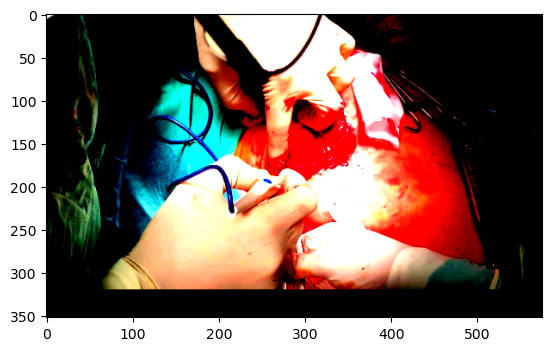

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


83
0
torch.Size([352, 576, 3])


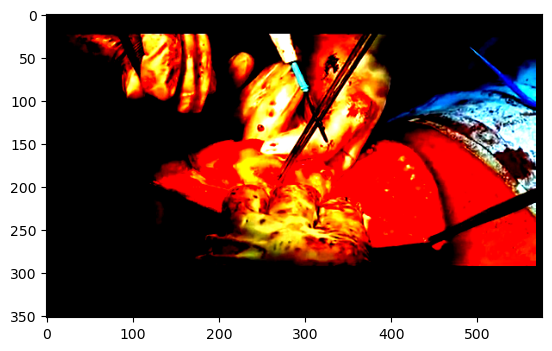

In [7]:
# Observe dataset 

import matplotlib.pyplot as plt 
import cv2 
from retinanet.dataloader import CocoDataset, CSVDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter, \
    UnNormalizer, Normalizer
unnormalize = UnNormalizer()

print(len(dataset_train)) 

for idx, sample in enumerate(dataset_train): 
        
    print(idx) 
    print(sample['img'].shape)  
    image = sample['img'] 
    plt.imshow(image) 
    plt.show() 
    
    if idx == 0: break 
        
        
print(len(dataset_val)) 

for idx, sample in enumerate(dataset_val): 
    
    print(idx) 
    print(sample['img'].shape)  
    image = sample['img'] 
    plt.imshow(image) 
    plt.show() 
    
    if idx == 0: break 

Using new Balanced Sampler
SHAPE (352, 576, 3)
erUVkDi6KqY_6694.jpg

Augmented 0
index:  71


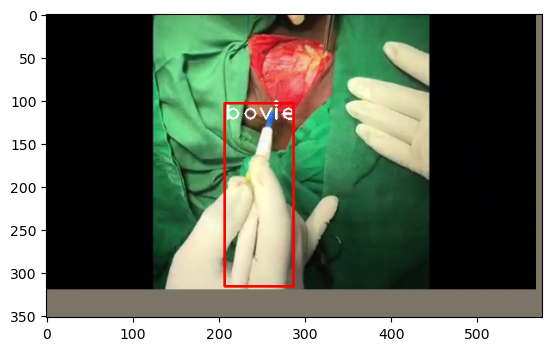

SHAPE (352, 576, 3)
iI09BTuD3xU_5348.jpg

Augmented 0
index:  115


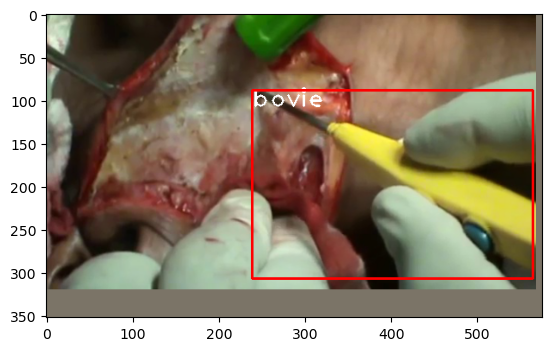

SHAPE (352, 576, 3)
oewplXxSMrk_2599.jpg

Augmented 0
index:  203


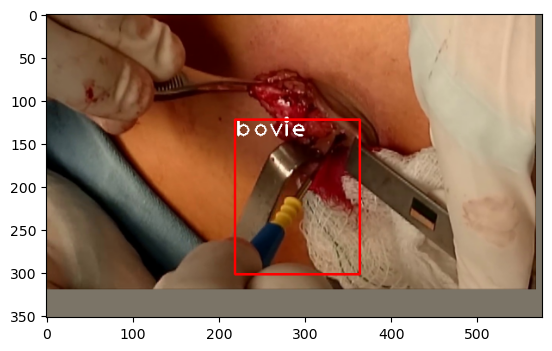

SHAPE (352, 576, 3)
Cczsz7JrUGU_13544.jpg

Augmented 0
index:  53


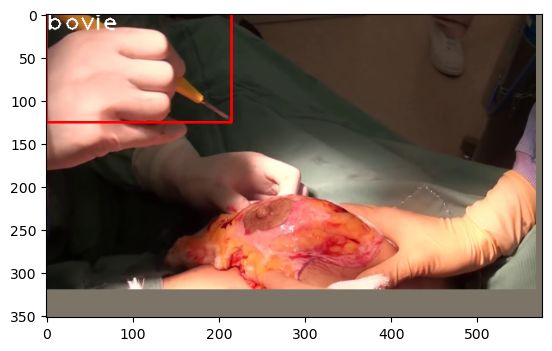

SHAPE (352, 576, 3)
g9lzOYtGLic_4453.jpg

Augmented 0
index:  99


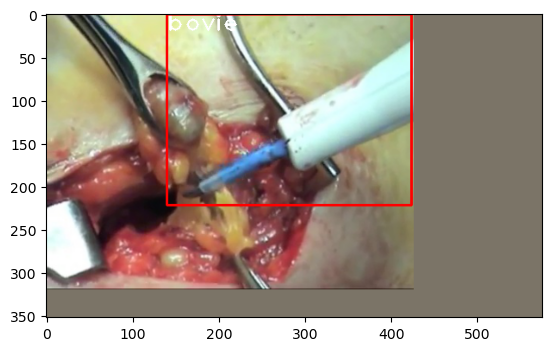

SHAPE (352, 576, 3)
EswP8VDC85s_1116.jpg

Augmented 0
index:  80


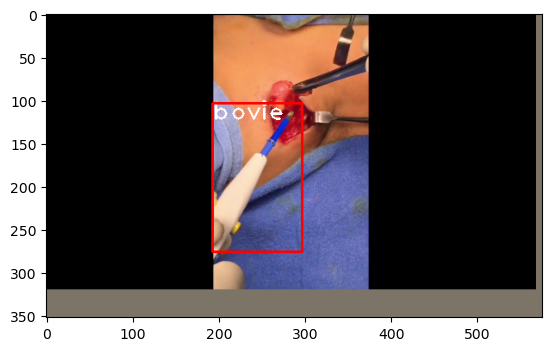

SHAPE (576, 448, 3)
3Ql0fGVrQeA_3378.jpg

Augmented 0
index:  24


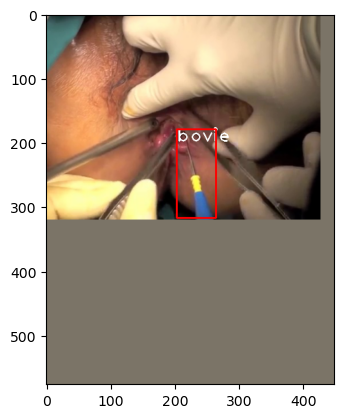

SHAPE (576, 448, 3)
_35HaYVPBIA_1460.jpg

Augmented 0
index:  381


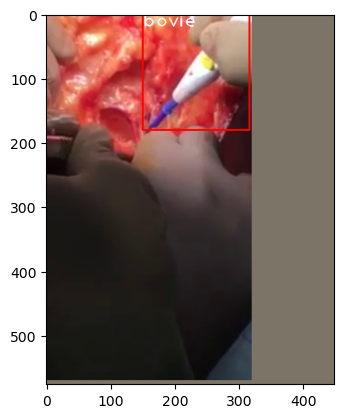

SHAPE (352, 576, 3)
TcYgRmsw_jg_1454.jpg

Augmented 0
index:  284


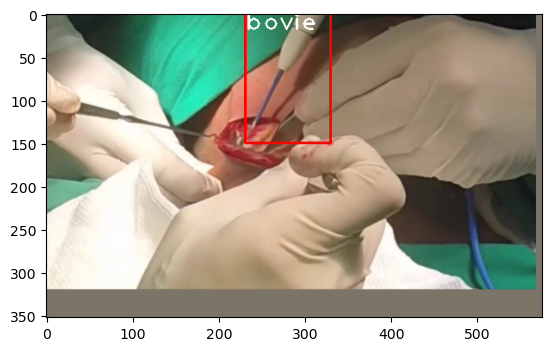

SHAPE (352, 576, 3)
ZP58Wx0QaWE_2053.jpg

Augmented 0
index:  373


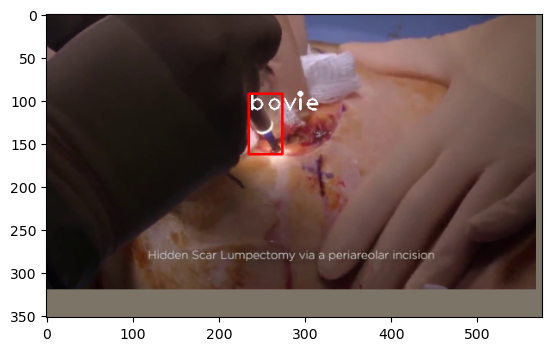

SHAPE (352, 576, 3)
StuUjtXj6u8_3214.jpg

Augmented 0
index:  259


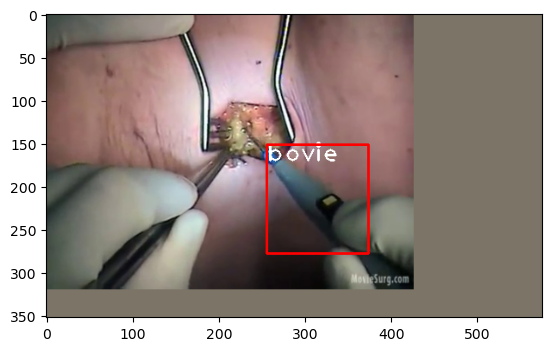

SHAPE (352, 576, 3)
bbI9l7j-LP4_1056.jpg
bbI9l7j
Augmented 0
index:  47


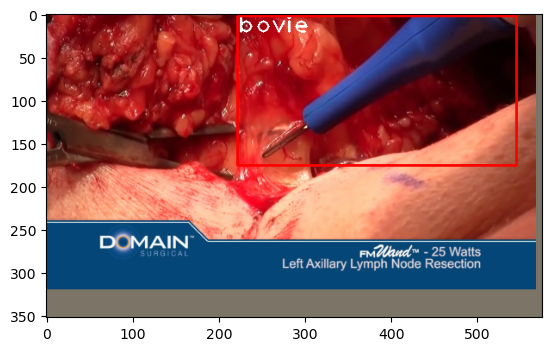

SHAPE (352, 576, 3)
bbI9l7j-LP4_1162.jpg
bbI9l7j
Augmented 0
index:  48


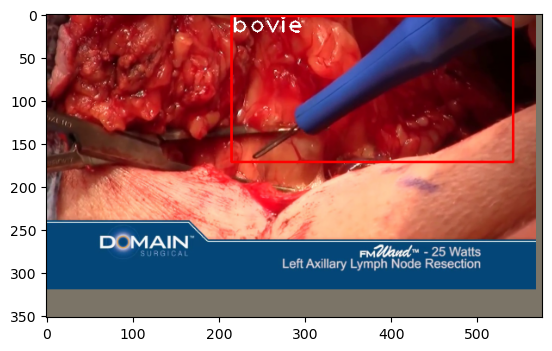

SHAPE (352, 576, 3)
kQTmL3C2dwE_5891.jpg

Augmented 0
index:  152


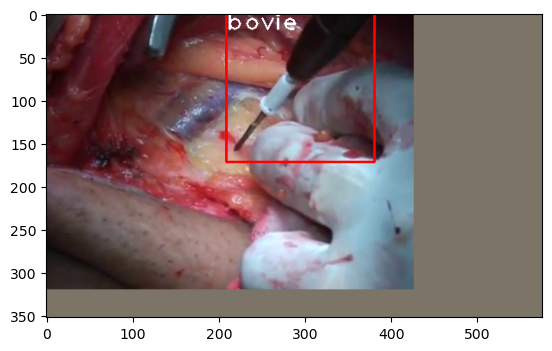

SHAPE (352, 576, 3)
OMK_iNu3gIE_10011.jpg

Augmented 0
index:  211


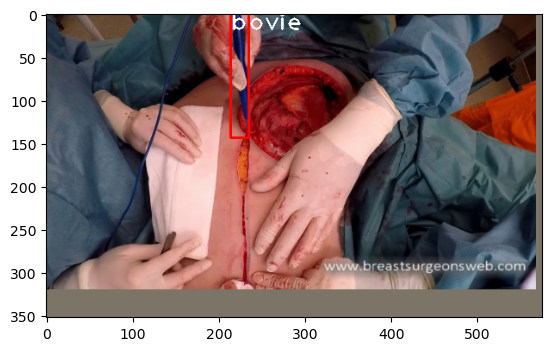

SHAPE (352, 576, 3)
1PwQrgU2Lic_13424.jpg

Augmented 0
index:  15


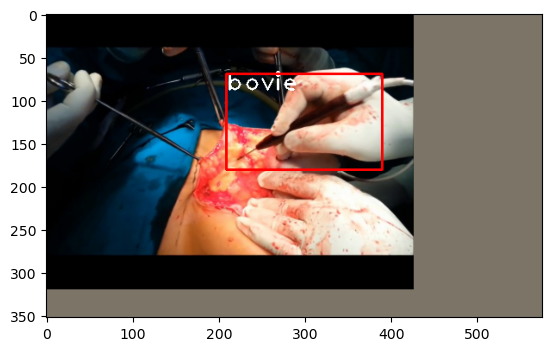

SHAPE (352, 576, 3)
OMK_iNu3gIE_11262.jpg

Augmented 0
index:  212


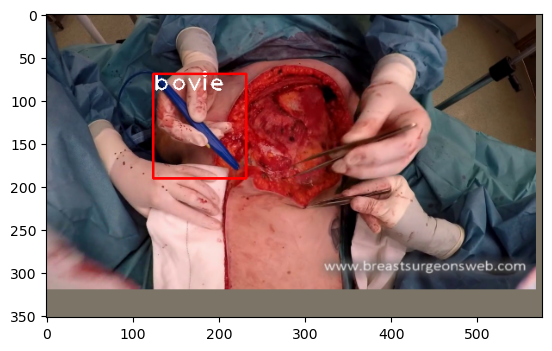

SHAPE (352, 576, 3)
zRk7vi3FsyU_5134.jpg

Augmented 0
index:  377


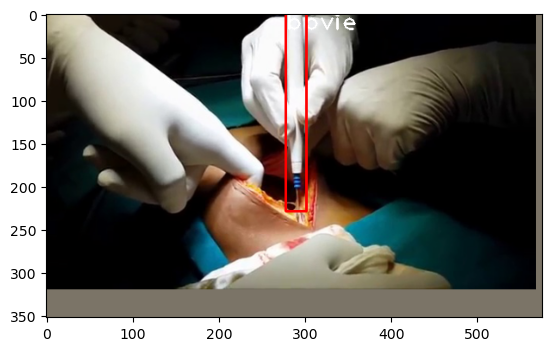

SHAPE (352, 576, 3)
dPvRrcSsc6Y_4413.jpg

Augmented 0
index:  62


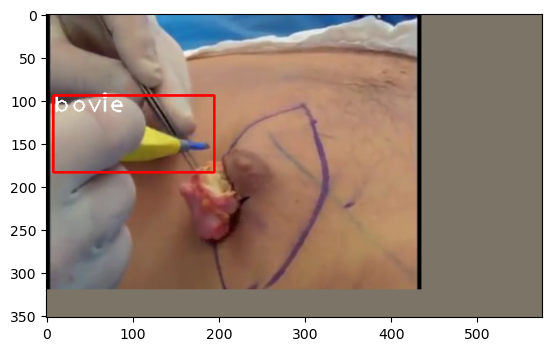

SHAPE (352, 576, 3)
feF1aRtVAvc_6948.jpg

Augmented 0
index:  84


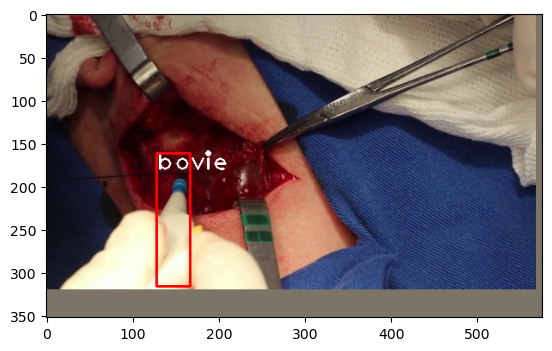

SHAPE (352, 576, 3)
jogJdtFU8SY_6344.jpg

Augmented 0
index:  134


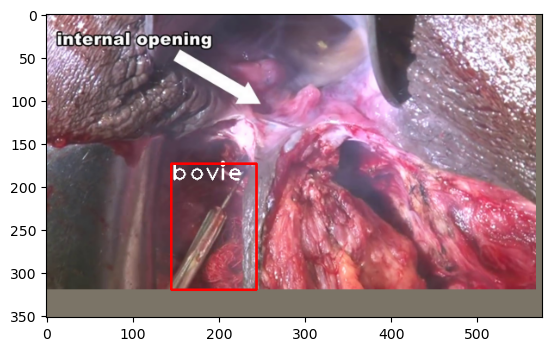

SHAPE (352, 576, 3)
1PwQrgU2Lic_21480.jpg

Augmented 0
index:  17


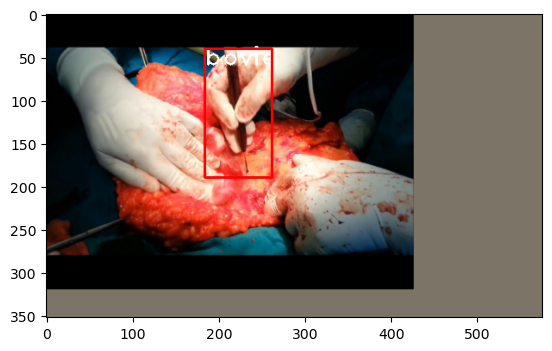

In [8]:
### Observe dataloader (Playing around cell)

import matplotlib.pyplot as plt 
import cv2 
from retinanet.dataloader import CocoDataset, CSVDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter, \
    UnNormalizer, Normalizer

unnormalize = UnNormalizer()

def draw_caption(image, box, caption): 
    b = np.array(box).astype(int)
    cv2.putText(image, caption, (b[0], b[1] + 20), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 2)
        

from collections import defaultdict 

class_indices_dict = aggregate_indices_per_class(dataset_train) 

for idx, data in enumerate(dataloader_train): 

    if idx > 10: break 

    for i in range(len(data['img'])): 
        
        img = np.array(255 * unnormalize(data['img'][i, :, :, :])).copy() # 1. Unnormalize 
        img[img < 0] = 0
        img[img > 255] = 255   
        img = np.transpose(img, (1, 2, 0))  # 2. Tranpose to correct channel in correct spot 

        
        batch_size = parser.batch_size, 
        
        print("SHAPE", img.shape)
        
        img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB) # 3. Convert to correct color space 
        
        filename = data['filename'][i] 
        filename = filename.rsplit('/',1)[1] 
        videoID = '-'.join(filename.split('-')[:-1]) 
        
        print(filename) 
        print(videoID) 
        
        augmented = data['augmented'][i] 
        print("Augmented", augmented) 
        
        index = data['index'][i] 
        print("index: ", index) 

        
        tools_present = False 
        bovi = False 
        need = False 
        forc = False 
        scal = False 
        
        annots = np.array(data['annot'][i]) 
        for annot in annots:
            if annot[4] == -1: 
                continue 
            label_name = dataset_val.labels[annot[4]]
            x1, y1, x2, y2 = int(annot[0]), int(annot[1]), int(annot[2]), int(annot[3])
            draw_caption(img, (x1, y1, x2, y2), label_name)
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=2)  
        
        plt.imshow(img[:, :, ::-1]) 
        plt.show() 

In [9]:
# Create the loggers 


writer = SummaryWriter('/home/egoodman/multitaskmodel/logs/{}'.format(model_name)) 

print('Logging training loss under {}_loss.csv'.format(LOG_DIR + model_name))
loss_f = open('{}_loss.csv'.format(LOG_DIR + model_name), 'w')
loss_logger = csv.writer(loss_f, delimiter=',')
loss_logger.writerow(['Epoch', 'Iteration', 'Classification Loss', 'Regression Loss', 'Running Loss'])

print('Logging training accuracy under {}_train.csv'.format(LOG_DIR + model_name))
train_f = open('{}_train.csv'.format(LOG_DIR + model_name), 'w')
train_logger = csv.writer(train_f, delimiter=',')
train_logger.writerow(['Epoch'] + [dataset_train.label_to_name(label) for label in (0, 2, 3)] #range(dataset_train.num_classes())]
                     + ['Overall']) 

if parser.csv_val is not None:
    print('Logging validation output under {}_validation.csv'.format(LOG_DIR + model_name))
    validation_f = open('{}_validation.csv'.format(LOG_DIR + model_name), 'w')
    val_logger = csv.writer(validation_f, delimiter=',')
    val_logger.writerow(
        ['Epoch'] + [dataset_val.label_to_name(label) for label in (0, 2, 3)] #range(dataset_val.num_classes())] 
                     + ['Overall'])


Logging training loss under /home/egoodman/multitaskmodel/logs/20210628_baseline_no_augmentation_no_pseudolabels/20210628_baseline_no_augmentation_no_pseudolabels_loss.csv
Logging training accuracy under /home/egoodman/multitaskmodel/logs/20210628_baseline_no_augmentation_no_pseudolabels/20210628_baseline_no_augmentation_no_pseudolabels_train.csv
Logging validation output under /home/egoodman/multitaskmodel/logs/20210628_baseline_no_augmentation_no_pseudolabels/20210628_baseline_no_augmentation_no_pseudolabels_validation.csv


## More model setup 

In [10]:
retinanet = model_label_prop.resnet50(num_classes=dataset_train.num_classes(), pretrained=True)
retinanet = retinanet.cuda()
retinanet = torch.nn.DataParallel(retinanet).cuda()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
retinanet.training = True

optimizer = optim.Adam(retinanet.parameters(), lr=learning_rate)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, factor=0.5, verbose=True)

loss_hist = collections.deque(maxlen=500)

retinanet.train()

print('Num training images: {}'.format(len(dataset_train)))

print('Num val images: {}'.format(len(dataset_val)))


Num training images: 383
Num val images: 83


## Training loop

In [12]:
import time
import matplotlib.pyplot as plt 
from collections import defaultdict 

t0 = time.time() 


for epoch_num in range(parser.epochs):
    
    retinanet.module.freeze_bn()

    epoch_loss = []    
    reg_loss = []
    class_loss = []
    

    for iter_num, data in enumerate(dataloader_train):  
                        
            retinanet.train()            

            optimizer.zero_grad()            
            
            classification_loss, regression_loss, action_logits = retinanet([data['img'].cuda().float(), data['annot']])


            classification_loss = classification_loss.mean()
            regression_loss = regression_loss.mean()
            
            class_loss.append(float(classification_loss.data))
            reg_loss.append(float(regression_loss.data))
            
            loss = classification_loss + regression_loss

            if bool(loss == 0):
                continue

            loss.backward()

            torch.nn.utils.clip_grad_norm_(retinanet.parameters(), 0.1)

            optimizer.step()

            loss_hist.append(float(loss.data))

            epoch_loss.append(float(loss.data))
            
            if iter_num % 20 == 0: 
                print('Epoch: {} | Iteration: {} | Classification loss: {:1.5f} | Regression loss: {:1.5f} | Running loss: {:1.5f}'.format(
                        epoch_num, iter_num, float(classification_loss), float(regression_loss), np.mean(loss_hist)))


            del classification_loss
            del regression_loss
            del action_logits
            del loss

    writer.add_scalar('loss/regression', np.mean(reg_loss), epoch_num)
    writer.add_scalar('loss/classification', np.mean(class_loss), epoch_num)
    writer.add_scalar('optimizerLR', optimizer.param_groups[0]['lr'], epoch_num)
        
    if epoch_num % 3 == 0:
        print('Evaluating dataset on training')
        train_mAP, train_pr = csv_eval.evaluate(train_acc_set, retinanet, iou_threshold=threshold)
        overall_train_mAP = np.mean(np.array([train_mAP[label][0] for label in (0, 1, 2, 3)])) #range(dataset_train.num_classes())])) 
        print("Overall: {}".format(overall_train_mAP)) 
        writer.add_scalar('mAP/train-overall', overall_train_mAP, epoch_num)
        writer.add_scalar('mAP/train-bovie', train_mAP[0][0], epoch_num)
        writer.add_scalar('mAP/train-forceps', train_mAP[1][0], epoch_num)
        writer.add_scalar('mAP/train-needledriver', train_mAP[2][0], epoch_num)
        writer.add_scalar('mAP/train-hand', train_mAP[3][0], epoch_num)


    if epoch_num % 3 == 0:
        print('\nEvaluating validation detections!')
        val_mAP, val_pr = csv_eval.evaluate(dataset_val, retinanet, iou_threshold=.5)
        overall_val_mAP = np.mean(np.array([val_mAP[label][0] for label in (0, 1, 2, 3)])) 
        print("Overall: {}".format(overall_val_mAP)) 
        writer.add_scalar('mAP/val-overall', overall_val_mAP, epoch_num)
        writer.add_scalar('mAP/val-bovie', val_mAP[0][0], epoch_num)
        writer.add_scalar('mAP/val-forceps', val_mAP[1][0], epoch_num)
        writer.add_scalar('mAP/val-needledriver', val_mAP[2][0], epoch_num)
        writer.add_scalar('mAP/val-hand', val_mAP[3][0], epoch_num)
                
    scheduler.step(np.mean(epoch_loss))

    torch.save(retinanet.module, '{}_{}_incomplete.pt'.format(LOG_DIR + model_name, epoch_num))
    


torch.save(retinanet, '{}_final.pt'.format(LOG_DIR + model_name)) 


Epoch: 0 | Iteration: 0 | Classification loss: 0.56595 | Regression loss: 0.52194 | Running loss: 1.08789
Epoch: 0 | Iteration: 20 | Classification loss: 0.25768 | Regression loss: 0.51656 | Running loss: 1.03531
Epoch: 0 | Iteration: 40 | Classification loss: 0.31958 | Regression loss: 0.49668 | Running loss: 0.92042
Epoch: 0 | Iteration: 60 | Classification loss: 0.28487 | Regression loss: 0.51487 | Running loss: 0.88994
Epoch: 0 | Iteration: 80 | Classification loss: 0.30439 | Regression loss: 0.49413 | Running loss: 0.86592
Epoch: 0 | Iteration: 100 | Classification loss: 0.21451 | Regression loss: 0.47746 | Running loss: 0.85390
Epoch: 0 | Iteration: 120 | Classification loss: 0.25115 | Regression loss: 0.44764 | Running loss: 0.84686
Epoch: 0 | Iteration: 140 | Classification loss: 0.30260 | Regression loss: 0.45025 | Running loss: 0.84230
Epoch: 0 | Iteration: 160 | Classification loss: 0.24432 | Regression loss: 0.49014 | Running loss: 0.82573
Epoch: 0 | Iteration: 180 | Classi

Epoch: 6 | Iteration: 180 | Classification loss: 0.05578 | Regression loss: 0.25737 | Running loss: 0.30013
Evaluating dataset on training
bovie Recall: 0.8803520605646631
bovie Precision: 0.3209778133131219

mAP:
bovie: 0.9099197462586899
forceps: 0
needledriver: 0
hand: 0
Overall: 0.22747993656467247

Evaluating validation detections!
bovie Recall: 0.6593418455465088
bovie Precision: 0.23196758263066547

mAP:
bovie: 0.45587335304899385
forceps: 0
needledriver: 0
hand: 0
Overall: 0.11396833826224846
Epoch: 7 | Iteration: 0 | Classification loss: 0.05445 | Regression loss: 0.17263 | Running loss: 0.29833
Epoch: 7 | Iteration: 20 | Classification loss: 0.10151 | Regression loss: 0.19864 | Running loss: 0.29560
Epoch: 7 | Iteration: 40 | Classification loss: 0.04211 | Regression loss: 0.07157 | Running loss: 0.28850
Epoch: 7 | Iteration: 60 | Classification loss: 0.01766 | Regression loss: 0.16715 | Running loss: 0.28378
Epoch: 7 | Iteration: 80 | Classification loss: 0.04306 | Regressio

Epoch: 13 | Iteration: 80 | Classification loss: 0.00636 | Regression loss: 0.04849 | Running loss: 0.16393
Epoch: 13 | Iteration: 100 | Classification loss: 0.01968 | Regression loss: 0.10253 | Running loss: 0.16255
Epoch: 13 | Iteration: 120 | Classification loss: 0.00881 | Regression loss: 0.11782 | Running loss: 0.16153
Epoch: 13 | Iteration: 140 | Classification loss: 0.02716 | Regression loss: 0.11826 | Running loss: 0.16036
Epoch: 13 | Iteration: 160 | Classification loss: 0.00168 | Regression loss: 0.00000 | Running loss: 0.15859
Epoch: 13 | Iteration: 180 | Classification loss: 0.01071 | Regression loss: 0.12468 | Running loss: 0.15719
Epoch: 14 | Iteration: 0 | Classification loss: 0.01845 | Regression loss: 0.14915 | Running loss: 0.15655
Epoch: 14 | Iteration: 20 | Classification loss: 0.02672 | Regression loss: 0.10472 | Running loss: 0.15502
Epoch: 14 | Iteration: 40 | Classification loss: 0.01641 | Regression loss: 0.07407 | Running loss: 0.15358
Epoch: 14 | Iteration: 6

Epoch: 20 | Iteration: 60 | Classification loss: 0.00571 | Regression loss: 0.08005 | Running loss: 0.10841
Epoch: 20 | Iteration: 80 | Classification loss: 0.00616 | Regression loss: 0.08934 | Running loss: 0.10890
Epoch: 20 | Iteration: 100 | Classification loss: 0.01621 | Regression loss: 0.11656 | Running loss: 0.10864
Epoch: 20 | Iteration: 120 | Classification loss: 0.00432 | Regression loss: 0.07549 | Running loss: 0.10783
Epoch: 20 | Iteration: 140 | Classification loss: 0.04048 | Regression loss: 0.15239 | Running loss: 0.10638
Epoch: 20 | Iteration: 160 | Classification loss: 0.05365 | Regression loss: 0.17289 | Running loss: 0.10643
Epoch: 20 | Iteration: 180 | Classification loss: 0.01397 | Regression loss: 0.09433 | Running loss: 0.10602
Epoch: 21 | Iteration: 0 | Classification loss: 0.01295 | Regression loss: 0.05829 | Running loss: 0.10604
Epoch: 21 | Iteration: 20 | Classification loss: 0.03493 | Regression loss: 0.09734 | Running loss: 0.10552
Epoch: 21 | Iteration: 4

Epoch: 27 | Iteration: 40 | Classification loss: 0.00389 | Regression loss: 0.06094 | Running loss: 0.09105
Epoch: 27 | Iteration: 60 | Classification loss: 0.00197 | Regression loss: 0.09684 | Running loss: 0.09074
Epoch: 27 | Iteration: 80 | Classification loss: 0.01114 | Regression loss: 0.13588 | Running loss: 0.09082
Epoch: 27 | Iteration: 100 | Classification loss: 0.00950 | Regression loss: 0.11108 | Running loss: 0.09031
Epoch: 27 | Iteration: 120 | Classification loss: 0.00168 | Regression loss: 0.08374 | Running loss: 0.09016
Epoch: 27 | Iteration: 140 | Classification loss: 0.00375 | Regression loss: 0.06099 | Running loss: 0.08822
Epoch: 27 | Iteration: 160 | Classification loss: 0.00184 | Regression loss: 0.08326 | Running loss: 0.08780
Epoch: 27 | Iteration: 180 | Classification loss: 0.00134 | Regression loss: 0.08980 | Running loss: 0.08813
Evaluating dataset on training
bovie Recall: 0.6608664772727273
bovie Precision: 0.895169179765826

mAP:
bovie: 0.9294045070607158


bovie Recall: 0.7398777437839938
bovie Precision: 0.7823088881149958

mAP:
bovie: 0.9360644242319716
forceps: 0
needledriver: 0
hand: 0
Overall: 0.2340161060579929

Evaluating validation detections!
bovie Recall: 0.5617015098722417
bovie Precision: 0.5059191331866302

mAP:
bovie: 0.555291593516357
forceps: 0
needledriver: 0
hand: 0
Overall: 0.13882289837908926
Epoch: 34 | Iteration: 0 | Classification loss: 0.00292 | Regression loss: 0.04757 | Running loss: 0.07579
Epoch: 34 | Iteration: 20 | Classification loss: 0.00356 | Regression loss: 0.09962 | Running loss: 0.07584
Epoch: 34 | Iteration: 40 | Classification loss: 0.00097 | Regression loss: 0.06408 | Running loss: 0.07576
Epoch: 34 | Iteration: 60 | Classification loss: 0.00573 | Regression loss: 0.10663 | Running loss: 0.07580
Epoch: 34 | Iteration: 80 | Classification loss: 0.00153 | Regression loss: 0.08108 | Running loss: 0.07602
Epoch: 34 | Iteration: 100 | Classification loss: 0.00304 | Regression loss: 0.06856 | Running los

Epoch: 40 | Iteration: 100 | Classification loss: 0.00077 | Regression loss: 0.04810 | Running loss: 0.06694
Epoch: 40 | Iteration: 120 | Classification loss: 0.00130 | Regression loss: 0.07098 | Running loss: 0.06694
Epoch: 40 | Iteration: 140 | Classification loss: 0.00673 | Regression loss: 0.09081 | Running loss: 0.06693
Epoch: 40 | Iteration: 160 | Classification loss: 0.00256 | Regression loss: 0.06683 | Running loss: 0.06706
Epoch: 40 | Iteration: 180 | Classification loss: 0.00115 | Regression loss: 0.07676 | Running loss: 0.06660
Epoch: 41 | Iteration: 0 | Classification loss: 0.00045 | Regression loss: 0.05023 | Running loss: 0.06655
Epoch: 41 | Iteration: 20 | Classification loss: 0.00075 | Regression loss: 0.03507 | Running loss: 0.06612
Epoch: 41 | Iteration: 40 | Classification loss: 0.00339 | Regression loss: 0.05645 | Running loss: 0.06582
Epoch: 41 | Iteration: 60 | Classification loss: 0.00117 | Regression loss: 0.04738 | Running loss: 0.06533
Epoch: 41 | Iteration: 8

Epoch: 47 | Iteration: 80 | Classification loss: 0.00175 | Regression loss: 0.08642 | Running loss: 0.06041
Epoch: 47 | Iteration: 100 | Classification loss: 0.00030 | Regression loss: 0.03891 | Running loss: 0.05974
Epoch: 47 | Iteration: 120 | Classification loss: 0.00162 | Regression loss: 0.03608 | Running loss: 0.05965
Epoch: 47 | Iteration: 140 | Classification loss: 0.00130 | Regression loss: 0.05552 | Running loss: 0.05932
Epoch: 47 | Iteration: 160 | Classification loss: 0.00132 | Regression loss: 0.06909 | Running loss: 0.05980
Epoch: 47 | Iteration: 180 | Classification loss: 0.00056 | Regression loss: 0.05707 | Running loss: 0.05930
Epoch: 48 | Iteration: 0 | Classification loss: 0.00155 | Regression loss: 0.06965 | Running loss: 0.05901
Epoch: 48 | Iteration: 20 | Classification loss: 0.00094 | Regression loss: 0.06077 | Running loss: 0.05875
Epoch: 48 | Iteration: 40 | Classification loss: 0.00055 | Regression loss: 0.01496 | Running loss: 0.05838
Epoch: 48 | Iteration: 6

Epoch: 54 | Iteration: 60 | Classification loss: 0.00024 | Regression loss: 0.02990 | Running loss: 0.05413
Epoch: 54 | Iteration: 80 | Classification loss: 0.00034 | Regression loss: 0.02395 | Running loss: 0.05447
Epoch: 54 | Iteration: 100 | Classification loss: 0.00038 | Regression loss: 0.04569 | Running loss: 0.05473
Epoch: 54 | Iteration: 120 | Classification loss: 0.00206 | Regression loss: 0.08228 | Running loss: 0.05512
Epoch: 54 | Iteration: 140 | Classification loss: 0.00116 | Regression loss: 0.06720 | Running loss: 0.05440
Epoch: 54 | Iteration: 160 | Classification loss: 0.00048 | Regression loss: 0.02850 | Running loss: 0.05401
Epoch: 54 | Iteration: 180 | Classification loss: 0.00026 | Regression loss: 0.04704 | Running loss: 0.05386
Evaluating dataset on training
bovie Recall: 0.5497419724770642
bovie Precision: 0.9818950281289278

mAP:
bovie: 0.9292811761229314
forceps: 0
needledriver: 0
hand: 0
Overall: 0.23232029403073284

Evaluating validation detections!
bovie Re

bovie Recall: 0.4632123341139735
bovie Precision: 0.7071266150259261

mAP:
bovie: 0.5501541512369454
forceps: 0
needledriver: 0
hand: 0
Overall: 0.13753853780923636
Epoch: 61 | Iteration: 0 | Classification loss: 0.00002 | Regression loss: 0.01066 | Running loss: 0.02131
Epoch: 61 | Iteration: 20 | Classification loss: 0.00002 | Regression loss: 0.01734 | Running loss: 0.02122
Epoch: 61 | Iteration: 40 | Classification loss: 0.00002 | Regression loss: 0.02546 | Running loss: 0.02107
Epoch: 61 | Iteration: 60 | Classification loss: 0.00006 | Regression loss: 0.01623 | Running loss: 0.02114
Epoch: 61 | Iteration: 80 | Classification loss: 0.00003 | Regression loss: 0.01778 | Running loss: 0.02148
Epoch: 61 | Iteration: 100 | Classification loss: 0.00009 | Regression loss: 0.02351 | Running loss: 0.02122
Epoch: 61 | Iteration: 120 | Classification loss: 0.00005 | Regression loss: 0.02367 | Running loss: 0.02102
Epoch: 61 | Iteration: 140 | Classification loss: 0.00002 | Regression loss: 0

Epoch: 67 | Iteration: 140 | Classification loss: 0.00004 | Regression loss: 0.03085 | Running loss: 0.02071
Epoch: 67 | Iteration: 160 | Classification loss: 0.00002 | Regression loss: 0.01869 | Running loss: 0.02073
Epoch: 67 | Iteration: 180 | Classification loss: 0.00027 | Regression loss: 0.02966 | Running loss: 0.02068
Epoch: 68 | Iteration: 0 | Classification loss: 0.00006 | Regression loss: 0.02331 | Running loss: 0.02069
Epoch: 68 | Iteration: 20 | Classification loss: 0.00021 | Regression loss: 0.02185 | Running loss: 0.02068
Epoch: 68 | Iteration: 40 | Classification loss: 0.00004 | Regression loss: 0.01681 | Running loss: 0.02077
Epoch: 68 | Iteration: 60 | Classification loss: 0.00002 | Regression loss: 0.00938 | Running loss: 0.02081
Epoch: 68 | Iteration: 80 | Classification loss: 0.00001 | Regression loss: 0.01273 | Running loss: 0.02069
Epoch: 68 | Iteration: 100 | Classification loss: 0.00003 | Regression loss: 0.01803 | Running loss: 0.02068
Epoch: 68 | Iteration: 12

Epoch: 74 | Iteration: 120 | Classification loss: 0.00001 | Regression loss: 0.00653 | Running loss: 0.01954
Epoch: 74 | Iteration: 140 | Classification loss: 0.00001 | Regression loss: 0.01118 | Running loss: 0.01954
Epoch: 74 | Iteration: 160 | Classification loss: 0.00005 | Regression loss: 0.02128 | Running loss: 0.01921
Epoch: 74 | Iteration: 180 | Classification loss: 0.00004 | Regression loss: 0.01105 | Running loss: 0.01910
Epoch: 75 | Iteration: 0 | Classification loss: 0.00011 | Regression loss: 0.01628 | Running loss: 0.01906
Epoch: 75 | Iteration: 20 | Classification loss: 0.00004 | Regression loss: 0.02272 | Running loss: 0.01900
Epoch: 75 | Iteration: 40 | Classification loss: 0.00003 | Regression loss: 0.01555 | Running loss: 0.01892
Epoch: 75 | Iteration: 60 | Classification loss: 0.00015 | Regression loss: 0.04734 | Running loss: 0.01899
Epoch: 75 | Iteration: 80 | Classification loss: 0.00003 | Regression loss: 0.04154 | Running loss: 0.01912
Epoch: 75 | Iteration: 10

Epoch: 81 | Iteration: 100 | Classification loss: 0.00006 | Regression loss: 0.02067 | Running loss: 0.01888
Epoch: 81 | Iteration: 120 | Classification loss: 0.00005 | Regression loss: 0.03428 | Running loss: 0.01905
Epoch: 81 | Iteration: 140 | Classification loss: 0.00008 | Regression loss: 0.00672 | Running loss: 0.01889
Epoch: 81 | Iteration: 160 | Classification loss: 0.00002 | Regression loss: 0.01764 | Running loss: 0.01898
Epoch: 81 | Iteration: 180 | Classification loss: 0.00001 | Regression loss: 0.01828 | Running loss: 0.01887
Evaluating dataset on training
bovie Recall: 0.509828415820643
bovie Precision: 0.9954781237969905

mAP:
bovie: 0.9321918351159919
forceps: 0
needledriver: 0
hand: 0
Overall: 0.23304795877899798

Evaluating validation detections!
bovie Recall: 0.4546387520525452
bovie Precision: 0.711973498517601

mAP:
bovie: 0.5472895178066576
forceps: 0
needledriver: 0
hand: 0
Overall: 0.1368223794516644
Epoch    82: reducing learning rate of group 0 to 2.5000e-06.


Epoch: 88 | Iteration: 0 | Classification loss: 0.00003 | Regression loss: 0.01321 | Running loss: 0.00753
Epoch: 88 | Iteration: 20 | Classification loss: 0.00000 | Regression loss: 0.00908 | Running loss: 0.00757
Epoch: 88 | Iteration: 40 | Classification loss: 0.00000 | Regression loss: 0.01219 | Running loss: 0.00760
Epoch: 88 | Iteration: 60 | Classification loss: 0.00001 | Regression loss: 0.00639 | Running loss: 0.00752
Epoch: 88 | Iteration: 80 | Classification loss: 0.00001 | Regression loss: 0.00486 | Running loss: 0.00755
Epoch: 88 | Iteration: 100 | Classification loss: 0.00002 | Regression loss: 0.01099 | Running loss: 0.00750
Epoch: 88 | Iteration: 120 | Classification loss: 0.00000 | Regression loss: 0.00853 | Running loss: 0.00749
Epoch: 88 | Iteration: 140 | Classification loss: 0.00001 | Regression loss: 0.00393 | Running loss: 0.00754
Epoch: 88 | Iteration: 160 | Classification loss: 0.00002 | Regression loss: 0.00505 | Running loss: 0.00750
Epoch: 88 | Iteration: 18

Epoch: 94 | Iteration: 180 | Classification loss: 0.00001 | Regression loss: 0.00541 | Running loss: 0.00725
Epoch: 95 | Iteration: 0 | Classification loss: 0.00001 | Regression loss: 0.00693 | Running loss: 0.00724
Epoch: 95 | Iteration: 20 | Classification loss: 0.00001 | Regression loss: 0.01208 | Running loss: 0.00726
Epoch: 95 | Iteration: 40 | Classification loss: 0.00000 | Regression loss: 0.00629 | Running loss: 0.00729
Epoch: 95 | Iteration: 60 | Classification loss: 0.00001 | Regression loss: 0.00883 | Running loss: 0.00737
Epoch: 95 | Iteration: 80 | Classification loss: 0.00000 | Regression loss: 0.00805 | Running loss: 0.00734
Epoch: 95 | Iteration: 100 | Classification loss: 0.00005 | Regression loss: 0.01077 | Running loss: 0.00737
Epoch: 95 | Iteration: 120 | Classification loss: 0.00001 | Regression loss: 0.00746 | Running loss: 0.00733
Epoch: 95 | Iteration: 140 | Classification loss: 0.00007 | Regression loss: 0.00753 | Running loss: 0.00734
Epoch: 95 | Iteration: 16

In [13]:
# from PIL import Image
# import torchvision.transforms.functional as TF
# import matplotlib

# # image = Image.open('YOUR_PATH')
# # x = TF.to_tensor(image)
# # x.unsqueeze_(0)
# # print(x.shape)

# # output = model(X)

# SCORE_THRESHOLD = 0.5
# MAX_DETECTIONS = 100

# def show_inference_on_image(image, annots):

#     image = TF.to_tensor(Image.open(image))

#     print("Image is of size", image.shape)
#     print("Using model", model)
#     print("Ground truth annotations are", gt_annots_list)
    
    
# model_loc = "../logs/20210622_one_delta_50/20210622_one_delta_50_99_incomplete.pt"
# model = torch.load(model_loc)
    
# dataset = dataset_val

# print("Studying dataset with {} images".format(len(dataset)))
    
# all_detections = [[None for i in range(dataset.num_classes())] for j in range(len(dataset))]

# retinanet.eval()   

# with torch.no_grad():

#     for index in range(len(dataset)):
                        
#         data = dataset[index]
#         scale = data["scale"]
        
#         data_loc = data["filename"]
                


#         input_data = data['img'].permute(2, 0, 1).cuda().float().unsqueeze(dim=0)

#         scores, labels, boxes, action_logits = model(input_data)

#         scores = scores[0].cpu().numpy()
#         labels = labels[0].cpu().numpy()
#         boxes = boxes[0].cpu().numpy()
        
#         boxes /= scale

#         indices = np.where(scores > SCORE_THRESHOLD)[0]

#         if indices.shape[0] > 0:
        
#             scores = scores[indices]
#             scores_sort = np.argsort(-scores)[:MAX_DETECTIONS]
            
#             image_boxes = boxes[indices[scores_sort], :]
#             image_scores = scores[scores_sort]
#             image_labels = labels[indices[scores_sort]]
#             image_detections = np.concatenate(
#                 [image_boxes, np.expand_dims(image_scores, axis=1), np.expand_dims(image_labels, axis=1)], axis=1)
            
#             # copy detections to all_detections
#             for label in range(dataset.num_classes()):
#                 all_detections[index][label] = image_detections[image_detections[:, -1] == label, :-1]

            

#         else:
#             # copy detections to all_detections
#             for label in range(dataset.num_classes()):
#                 all_detections[index][label] = np.zeros((0, 5))  

                
#         fig_hist, ax_hist = plt.subplots(figsize=(5, 4))
#         show_frame = matplotlib.image.imread(data_loc)
#         for det in all_detections[index][3]:
#             cv2.rectangle(show_frame, (det[0], det[1]), (det[2], det[3]), color=(5, 255, 255), thickness=15)
        
#         plt.imshow(show_frame)

        
#         if index == 50:
#             break
        
#         #a list of all_dataset.shape = (len_dataset, 4, number_of_detections_in_each_class)